In [1]:
import pandas as pd
import pandas_datareader
import datetime
import math
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
import statsmodels.tsa.api as smtsa
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

In [10]:
# 1. 准备数据
# 指定股票分析开始日期
start_date = datetime.datetime(2010, 1, 1)
# 指定股票分析截止日期
end_date = datetime.datetime(2016, 12, 30)
# 股票代码
stock_code = '600519.SS'
stock = pandas_datareader.data.DataReader(stock_code, 'yahoo', start_date, end_date)

In [11]:
print(start_date)

2010-01-01 00:00:00


In [12]:
#将数据写入文件
stock.head()
stock.to_csv("stock_train.csv")

                  High         Low        Open       Close     Volume  \
Date                                                                    
2010-01-04  129.226151  127.205109  129.226151  127.678436  5896979.0   
2010-01-05  128.850494  126.972198  128.467316  127.302780  4194404.0   
2010-01-06  127.347855  124.951164  126.964691  125.289253  5309229.0   
2010-01-07  125.612320  121.622841  125.289253  123.005257  6498680.0   
2010-01-08  123.215630  120.285500  123.215630  121.712997  4885048.0   

             Adj Close  
Date                    
2010-01-04  105.634399  
2010-01-05  105.323608  
2010-01-06  103.657715  
2010-01-07  101.768059  
2010-01-08  100.698906  


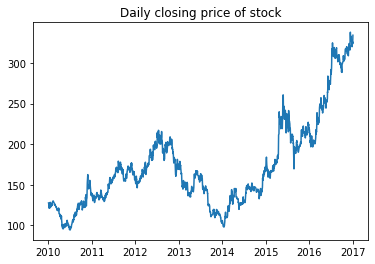

In [13]:
stock_df = pd.read_csv("stock_train.csv", index_col = 0, parse_dates=[0])
# 预览数据
print(stock_df.head())
plt.plot(stock_df['Close'])
plt.title('Daily closing price of stock')
plt.show()

In [14]:
# #输出数据缺失值填充之前的数据
# print(stock_df.Close['20100104': '20100120'])
# #数据缺失值填充及可视化
# #这里以天为单位，把缺失数据填充上，这里填充的线性取值
# stock_df = stock_df.resample('D').interpolate('linear')
# print(stock_df.Close['20100104': '20100120'])

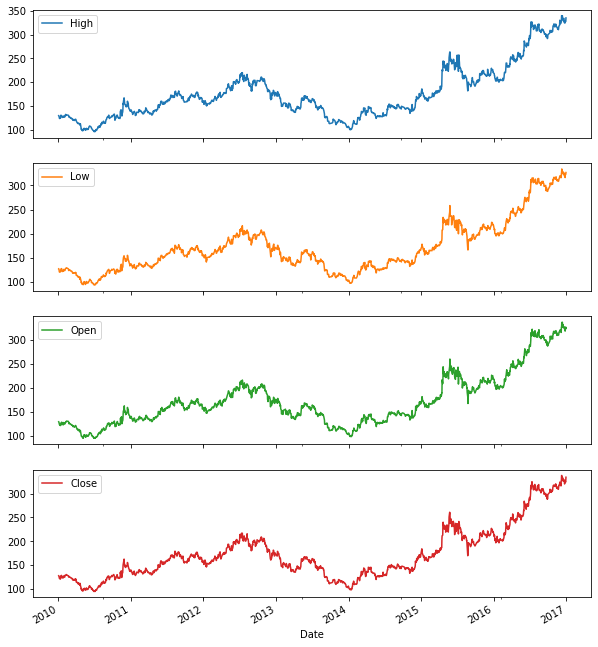

In [15]:
stock_df = stock_df[['High', 'Low', 'Open', 'Close']]
stock_df.plot(subplots = True, figsize = (10, 12))
plt.savefig('stocks_df.png')
plt.show()

In [16]:
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
        xt = pd.Series(xt)
    plt.figure(figsize = fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf = plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = nlag, ax = ax_acf)
    plot_pacf(xt, lags = nlag, ax = ax_pacf)
    plt.tight_layout()
    return None

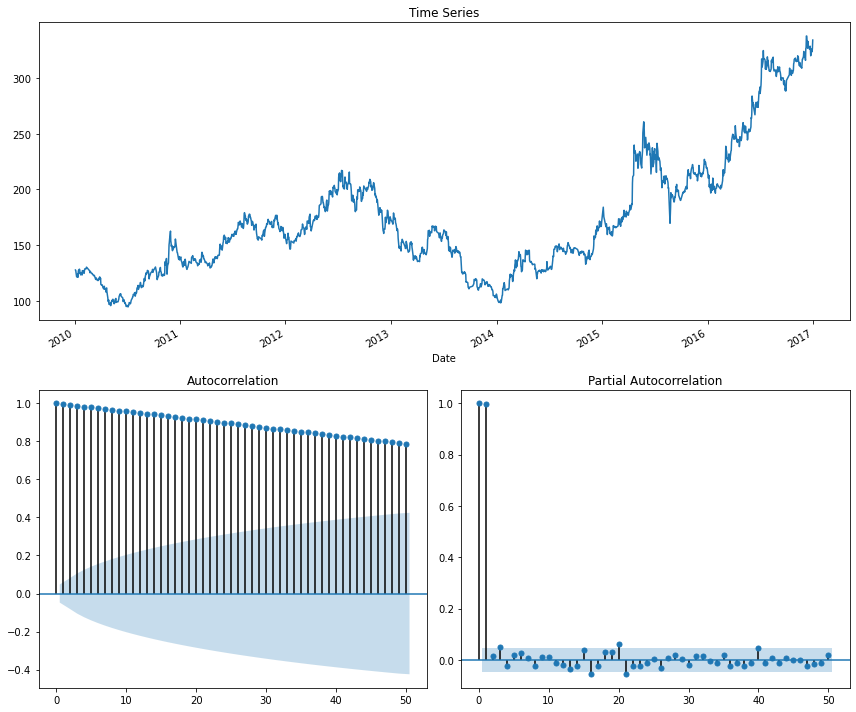

In [17]:
#画出acf，pacf图像
plotds(stock_df['Close'].dropna(), nlag = 50)

In [18]:
#平稳性检验
diff = 0
adf = ADF(stock_df['Close'])
if adf[1] > 0.05:
    print(u'原始序列经检验不平稳，p值为:%s'%(adf[1]))
else:
    print(u'原始序列经检验平稳，p值为:%s'%(adf[1]))

原始序列经检验不平稳，p值为:0.9512751521988012


In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
[[lb],[p]]=acorr_ljungbox(stock_df['Close'],lags=1)
if p<0.05:
    print (u'一阶差分序列为非白噪声序列，p值为:%s'%p)
else:
    print (u'一阶差分序列为白噪声序列，p值为:%s'%p)

一阶差分序列为非白噪声序列，p值为:0.0


E:\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


                High       Low      Open     Close
Date                                              
2010-01-05 -0.375656 -0.232910 -0.758835 -0.375656
2010-01-06 -1.502640 -2.021034 -1.502625 -2.013527
2010-01-07 -1.735535 -3.328323 -1.675438 -2.283997
2010-01-08 -2.396690 -1.337341 -2.073624 -1.292259
2010-01-11  0.676178  0.300522 -0.300529 -0.533432
High     float64
Low      float64
Open     float64
Close    float64
dtype: object
Date
2010-01-05   -0.375656
2010-01-06   -2.013527
2010-01-07   -2.283997
2010-01-08   -1.292259
2010-01-11   -0.533432
                ...   
2016-12-26    4.450012
2016-12-27    1.679993
2016-12-28   -2.440002
2016-12-29    3.589996
2016-12-30    6.839996
Name: Close, Length: 1697, dtype: float64


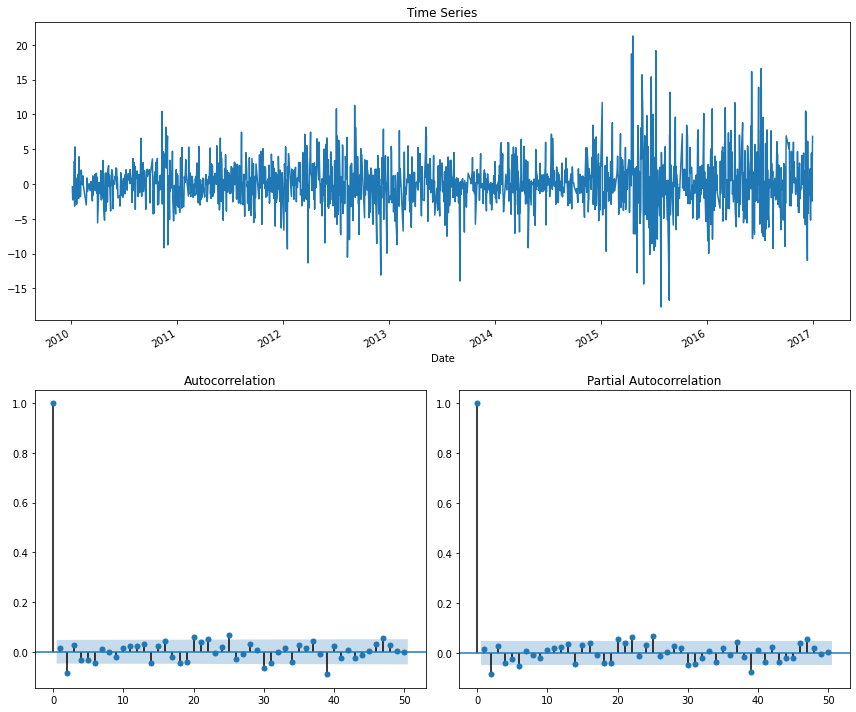

In [20]:
# 3. 处理数据，平稳化数据
# 这里只是简单第做了一节差分，还有其他平稳化时间序列的方法
# 可以查询资料后改进这里的平稳化效果
stock_diff = stock_df.diff(1)
diff = stock_diff.dropna()
print(diff.head())
print(diff.dtypes)
print(diff['Close'])
plotds(diff['Close'].dropna(), nlag = 50)

In [10]:
#平稳性检验
adf = ADF(diff['Close'])
print(diff.dtypes)
if adf[1] > 0.05:
    print(u'原始序列经检验不平稳，p值为:%s'%(adf[1]))
else:
    print(u'原始序列经检验平稳，p值为:%s'%(adf[1]))

High     float64
Low      float64
Open     float64
Close    float64
dtype: object
原始序列经检验平稳，p值为:0.0


In [14]:
#白噪声检验
[[lb],[p]]=acorr_ljungbox(diff['Close'],lags=1)
if p<0.05:
    print (u'一阶差分序列为非白噪声序列，p值为:%s'%p)
else:
    print (u'一阶差分序列为白噪声序列，p值为:%s'%p)

一阶差分序列为非白噪声序列，p值为:3.84830187553991e-07


In [11]:
# 4. 根据ACF和PACF定阶并建立模型
model = ARIMA(stock_df['Close'], order = (2, 1, 2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/hesiyao/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2552
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6008.501
Method:                       css-mle   S.D. of innovations              2.548
Date:                Mon, 10 May 2021   AIC                          12029.002
Time:                        13:55:24   BIC                          12064.070
Sample:                    01-05-2010   HQIC                         12041.720
                         - 12-30-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0812      0.057      1.436      0.151      -0.030       0.192
ar.L1.D.Close    -0.5127      0.249     -2.060      0.039      -1.000      -0.025
ar.L2.D.Close     0.2269      0.152     

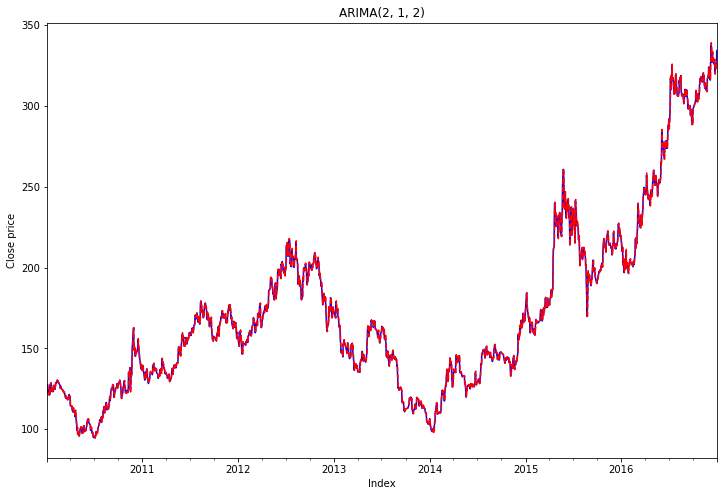

In [12]:
#模型拟合
stock_df['ARIMA'] = model_fit.predict(typ='levels')
f, axarr = plt.subplots(1, sharex = True)
f.set_size_inches(12, 8)
stock_df['Close'].plot(color = 'b', linestyle = '-', ax = axarr)
stock_df['ARIMA'].plot(color = 'r', linestyle = '--', ax = axarr)
axarr.set_title('ARIMA(2, 1, 2)')
plt.xlabel('Index')
plt.ylabel('Close price')
plt.show()

In [13]:
 #5. 预测
output = model_fit.predict('20120201', '20120207', dynamic=True, typ='levels')
print(output)

Date
2012-02-01    154.354580
2012-02-02    154.425295
2012-02-03    154.560727
2012-02-04    154.611685
2012-02-05    154.720640
2012-02-06    154.780689
2012-02-07    154.878975
Freq: D, dtype: float64


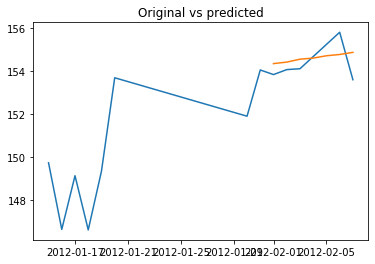

In [14]:
# 6. 可视化预测结果
#print(stock_df.Close['20110201': '20130207'])
stock_forcast = pd.concat([stock_df.Close['20120115': '20120207'], output], axis=1, keys=['original', 'predicted'])
plt.figure()
plt.plot(stock_forcast)
plt.title('Original vs predicted')
plt.savefig('./stock_pred.png', format='png')
plt.show()

In [67]:
#模型评估，平均绝对误差MAE、均方误差MSE、均方根误差RMSE 
#对短期预测结果进行评估
short_label = stock_df.Close['20120201': '20120202']
short_prediction = output[:2]
short_mse_score = mse(short_label, short_prediction)
short_rmse_score = math.sqrt(mse(short_label, short_prediction))
short_mae_score = mae(short_label, short_prediction)
print('short_MSE: %.4f, short_RMSE: %.4f, short_MAE: %.4f' % (short_mse_score, short_rmse_score, short_mae_score))

#对长期预测结果进行评估
all_label = stock_df.Close['20120201': '20120207']
all_prediction = output
long_mse_score = mse(all_label, all_prediction)
long_rmse_score = math.sqrt(mse(all_label, all_prediction))
long_mae_score = mae(all_label, all_prediction)
print('long_MSE: %.4f, long_RMSE: %.4f, long_MAE: %.4f' % (long_mse_score, long_rmse_score, long_mae_score))

short_MSE: 0.1924, short_RMSE: 0.4387, short_MAE: 0.4313
long_MSE: 0.5104, long_RMSE: 0.7144, long_MAE: 0.6032


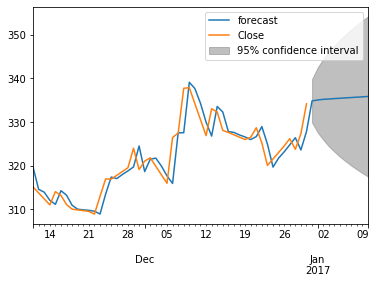

In [15]:
#对后续数据进行预测
fig = model_fit.plot_predict(len(stock_df)-50, len(stock_df)+10)
predict = model_fit.predict(start = 1, end = len(stock_df)+10)
#predict[len(predict)-10:]